In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import dataloader
import modules 
import plots
import utilities
from trainer import Trainer
import torch 
import matplotlib.pyplot as plt
from matplotlib_style import setup_matplotlib_environment, theme_categorical_bright

In [3]:
setup_matplotlib_environment()

# Test on Kaggle Housing Dataset

## Train a test model

To begin with, we will train a simple model on the Kaggle House Prices dataset. We will use a simple MLP with a two hidden layers, each with 32 neurons. Since the Kaggle dataset doesn't have a validation set, we will eventually use a 5-fold cross validation to evaluate the model, but in this initial example let's just see if we can reduce the training error.

In [57]:
data = dataloader.KaggleHouse(batch_size=64)
data.preprocess()

In [64]:
network_architecture = [32, 32]
model = modules.LinearReLUMLP(network_architecture, learning_rate=0.006, weight_decay=0.1)

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [65]:
trainer = Trainer(max_epochs=25)
trainer.fit(model, data)

Model running on cpu


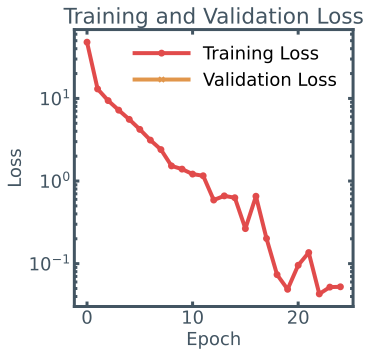

In [66]:
losses = utilities.extract_training_losses(trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')

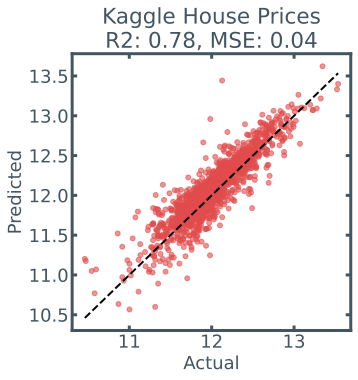

In [67]:
fig, ax = plots.correlate_y_vs_yhat(*utilities.get_model_predictions(model, data, train=True), title="Kaggle House Prices")

## K-Fold Cross Validation

In [ ]:
def k_fold_data(data: dataloader.LinearReLUMLPDataSet, k: int):
    """
    Splits the data into k folds for k-fold cross validation.
    """
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(dataloader.KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

def k_fold(trainer, data, network_architecture, k, lr):
    models, data_folds = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = modules.LinearReLUMLP(network_architecture, learning_rate=0.01)
        trainer.fit(model, data_fold)
        models.append(model)
        data_folds.append(data_fold)
    return models, data_folds

In [68]:
models, data_folds = k_fold(trainer, data, network_architecture=[32, 32], k=5, lr=0.1)

NameError: name 'k_fold' is not defined

In [12]:
k_fold_y = []
k_fold_y_hat = []

for i, (model, data_fold) in enumerate(zip(models, data_folds)):
    y = torch.tensor(data_fold.val["SalePrice"].values.astype(float), dtype=torch.float32)
    y_hat = torch.exp(model(torch.tensor(data_fold.val.drop(columns="SalePrice").values.astype(float), dtype=torch.float32)))

    k_fold_y.append(y.detach().numpy())
    k_fold_y_hat.append(y_hat.detach().numpy())

In [13]:
print(len(k_fold_y), len(k_fold_y_hat))

5 5


[autoreload of dataloader failed: Traceback (most recent call last):
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'KaggleHouse' object layout differ

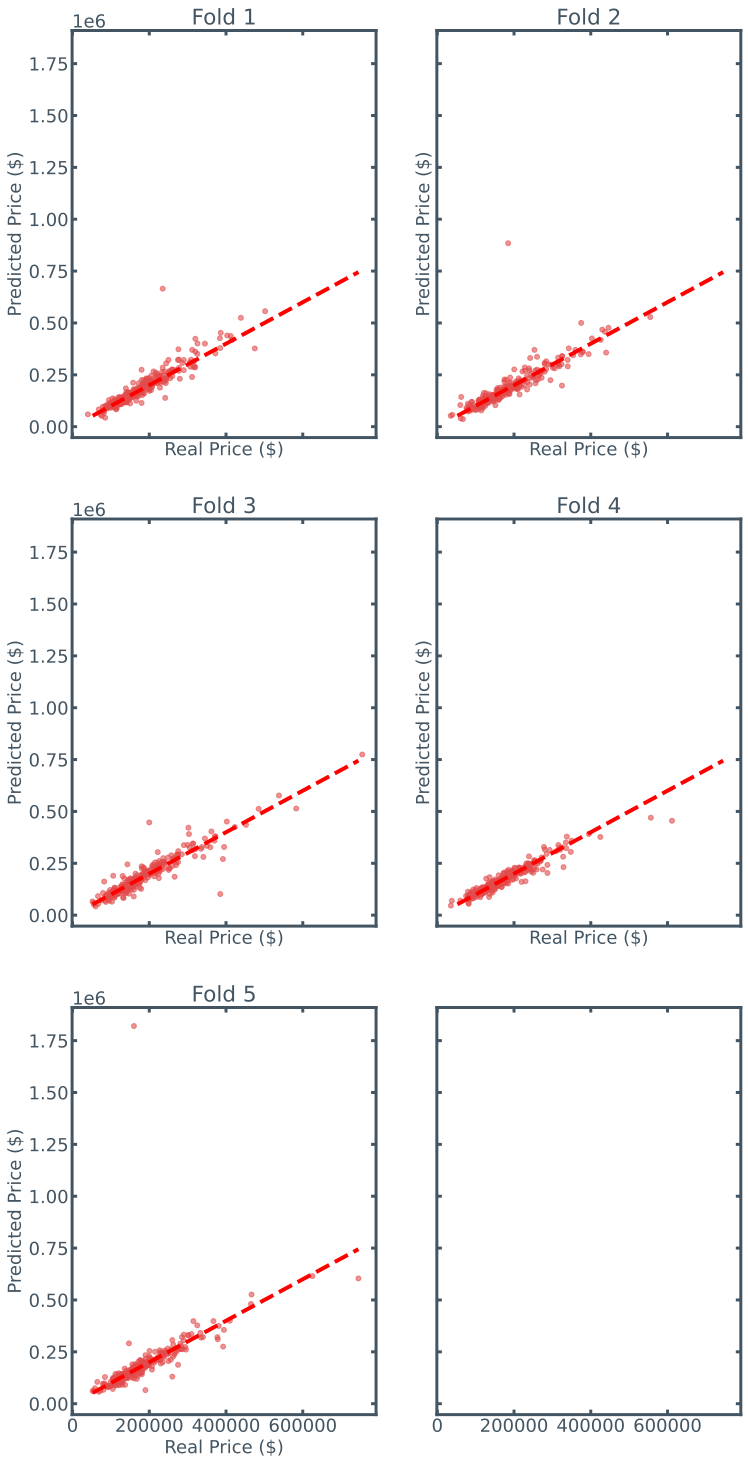

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=len(k_fold_y) // 2 + 1, figsize=(12, 5 * len(k_fold_y)), sharex=True, sharey=True)


for i, subplot_ax in zip(range(len(k_fold_y)), ax.ravel()):
    subplot_ax.scatter(k_fold_y[i], k_fold_y_hat[i], alpha=0.6, marker='.', c=theme_categorical_bright[0], label='Predicted')
    subplot_ax.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='dashed', label='Real')
    subplot_ax.set_title(f'Fold {i+1}')
    subplot_ax.set_ylabel('Predicted Price ($)')
    subplot_ax.set_xlabel('Real Price ($)')
# add a line
